__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.1　モニタリング指標の異常検知によるキャンペーン評価（自動車ディーラー）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from pmdarima import utils
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_1.csv'
df=pd.read_csv(
    dataset,             #読み込むデータセット
    index_col='yyyymm',  #変数「Month」をインデックスに設定
    parse_dates=True)   #インデックスを日付型に設定

print(df.head()) #確認(上から5番目まで)
print(df.tail()) #確認(下から5番目まで)

            sales
yyyymm           
2014-01-01   1717
2014-02-01   2490
2014-03-01   5040
2014-04-01   1373
2014-05-01   2233
            sales
yyyymm           
2018-02-01   4805
2018-03-01   7409
2018-04-01   3094
2018-05-01   3760
2018-06-01   5442


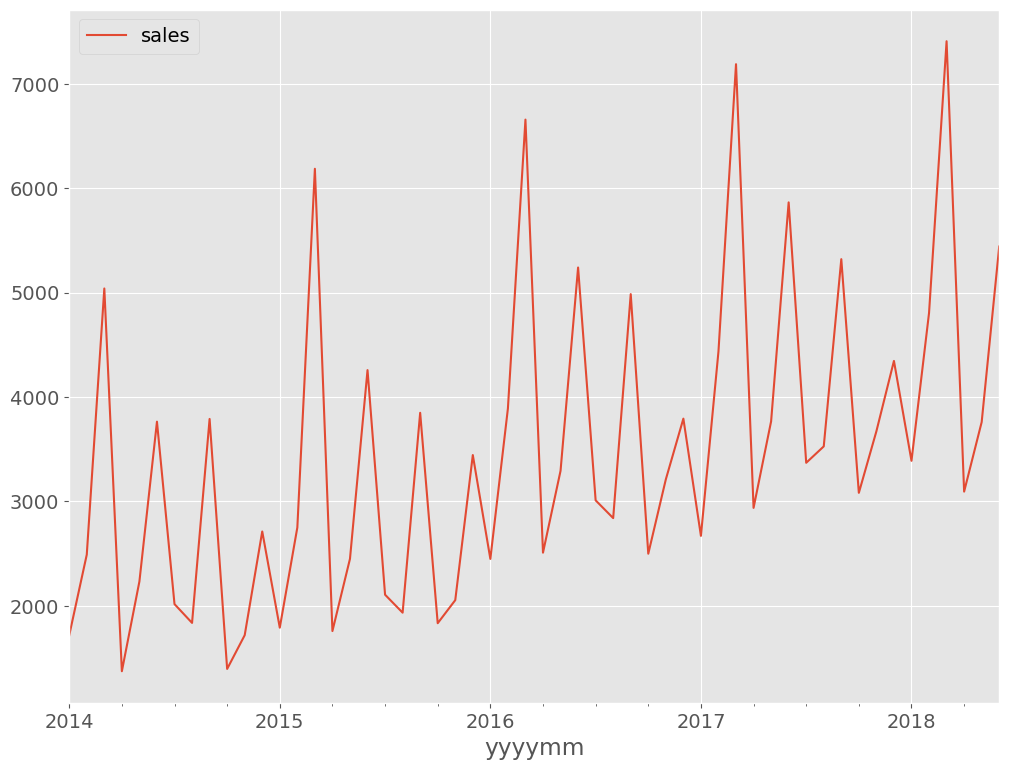

In [3]:
#
# グラフ化
#

df.plot()
plt.show()

### モデル構築用データと評価対象データ（直近6ヶ月間）に分割

In [4]:
#
# データセットをモデル構築用データと評価対象データ（直近6ヶ月間）に分割
#

target_length = 6

df_train, df_target = train_test_split(
    df,test_size=target_length)

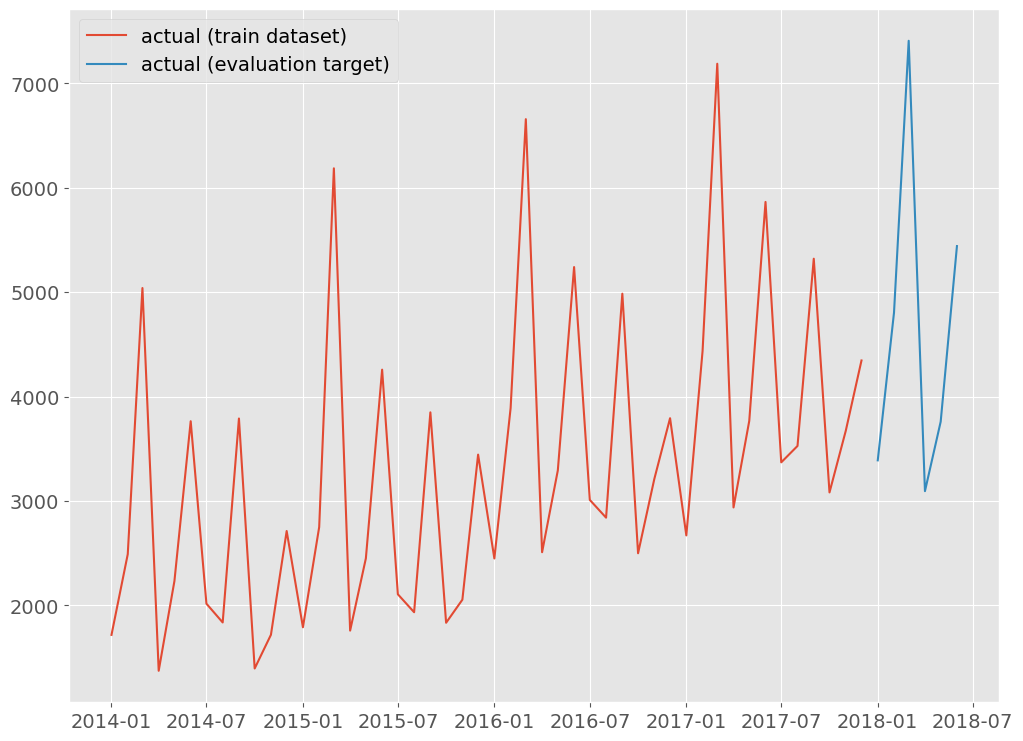

In [5]:
# グラフ化
fig, ax = plt.subplots()

ax.plot(
    df_train.index, 
    df_train.sales, 
    label="actual (train dataset)")
ax.plot(
    df_target.index, 
    df_target.sales, 
    label="actual (evaluation target)")

plt.legend()
plt.show()

## ステップ2：異常検知で利用するモデルの構築

### 予測モデルの学習（モデル構築用データ利用）

In [6]:
#
# 予測モデルの学習（モデル構築用データ利用）
#

arima_model = auto_arima(
    df_train.sales, 
    seasonal=True,
    m=12)

### モデル構築用データの期間を予測

In [7]:
#
# 予測の実施（モデル構築用データの期間）
#

train_pred = arima_model.predict_in_sample()

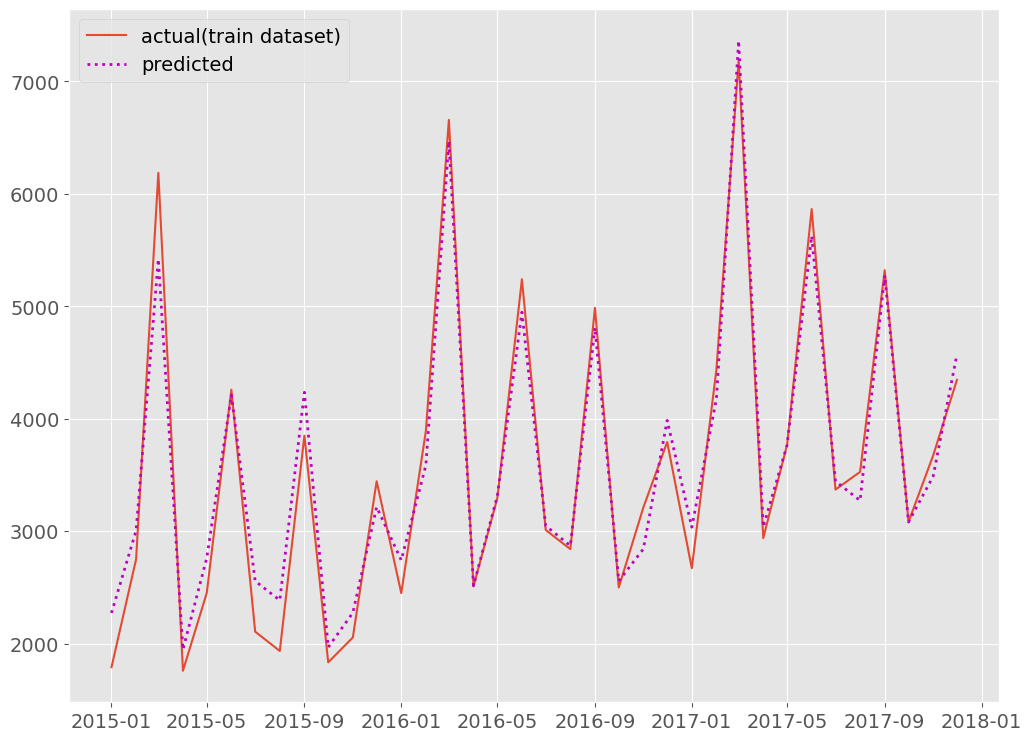

In [8]:
#
# グラフ（予測値と実測値）※最初の12ヶ月カット
#

fig, ax = plt.subplots()

ax.plot(
    df_train.index[12:], 
    df_train.sales[12:], 
    label="actual(train dataset)")
ax.plot(
    df_train.index[12:], 
    train_pred[12:], 
    label="predicted", 
    linestyle="dotted", 
    lw=2,color="m")

ax.legend()
plt.show()

### 残差（最初の12ヶ月カット）と外れ値スコアの計算

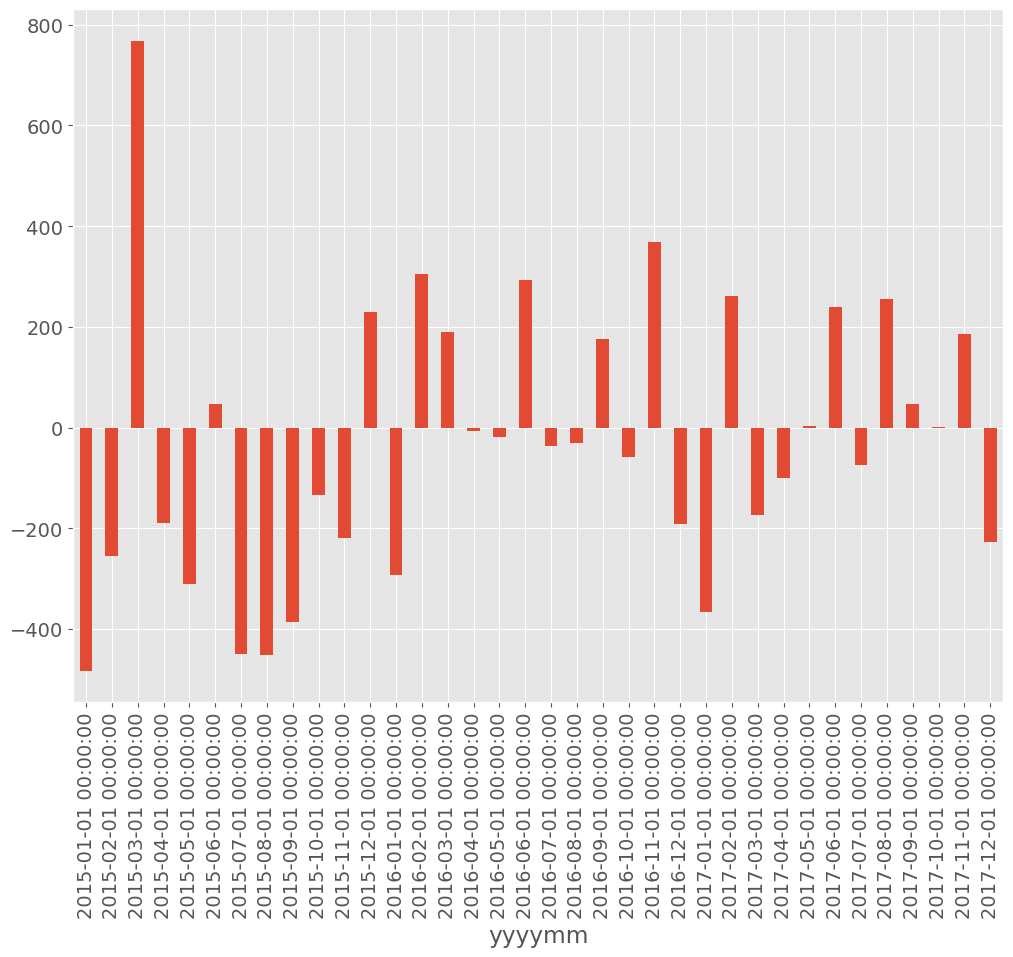

In [9]:
#
# 残差（実測値－予測値）※最初の12ヶ月カット
#

res = df_train.sales[12:]-train_pred[12:]

# グラフ化
res.plot(kind='bar')
plt.show()

In [10]:
#
# 残差の基本統計量
#

res_sta = res.describe()
res_sta

count     36.000000
mean     -30.050356
std      274.227566
min     -482.518921
25%     -221.284065
50%      -33.856714
75%      186.384816
max      768.412688
Name: sales, dtype: float64

In [11]:
#
# 残差を標準化（平均0、分散1に正規化）
#

res_data = res.values.reshape(-1, 1) #NumPy配列に変換
scaler = StandardScaler() #標準化モデルのインスタンス
res_data_ss = scaler.fit_transform(res_data) #標準化モデルの学習と標準化

In [12]:
#
# 外れ値スコアなどを計算しres_dfに結果集約
#

res_df = df_train[12:].copy() #日付とsales
res_df['pred'] = train_pred[12:] #予測値
res_df['residual'] = res_data #残差
res_df['std_res'] = res_data_ss #標準化した残差
res_df['abs_std_res'] = abs(res_data_ss) #外れ値スコア

# 確認
print(res_df)

            sales         pred    residual   std_res  abs_std_res
yyyymm                                                           
2015-01-01   1790  2272.518921 -482.518921 -1.673380     1.673380
2015-02-01   2750  3004.360891 -254.360891 -0.829575     0.829575
2015-03-01   6187  5418.587312  768.412688  2.952983     2.952983
2015-04-01   1758  1946.835043 -188.835043 -0.587239     0.587239
2015-05-01   2450  2761.044738 -311.044738 -1.039211     1.039211
2015-06-01   4258  4210.527346   47.472654  0.286706     0.286706
2015-07-01   2106  2555.598803 -449.598803 -1.551630     1.551630
2015-08-01   1934  2385.182820 -451.182820 -1.557488     1.557488
2015-09-01   3849  4235.142988 -386.142988 -1.316949     1.316949
2015-10-01   1833  1967.663663 -134.663663 -0.386895     0.386895
2015-11-01   2054  2273.465676 -219.465676 -0.700521     0.700521
2015-12-01   3444  3214.540603  229.459397  0.959754     0.959754
2016-01-01   2449  2741.960507 -292.960507 -0.972330     0.972330
2016-02-01

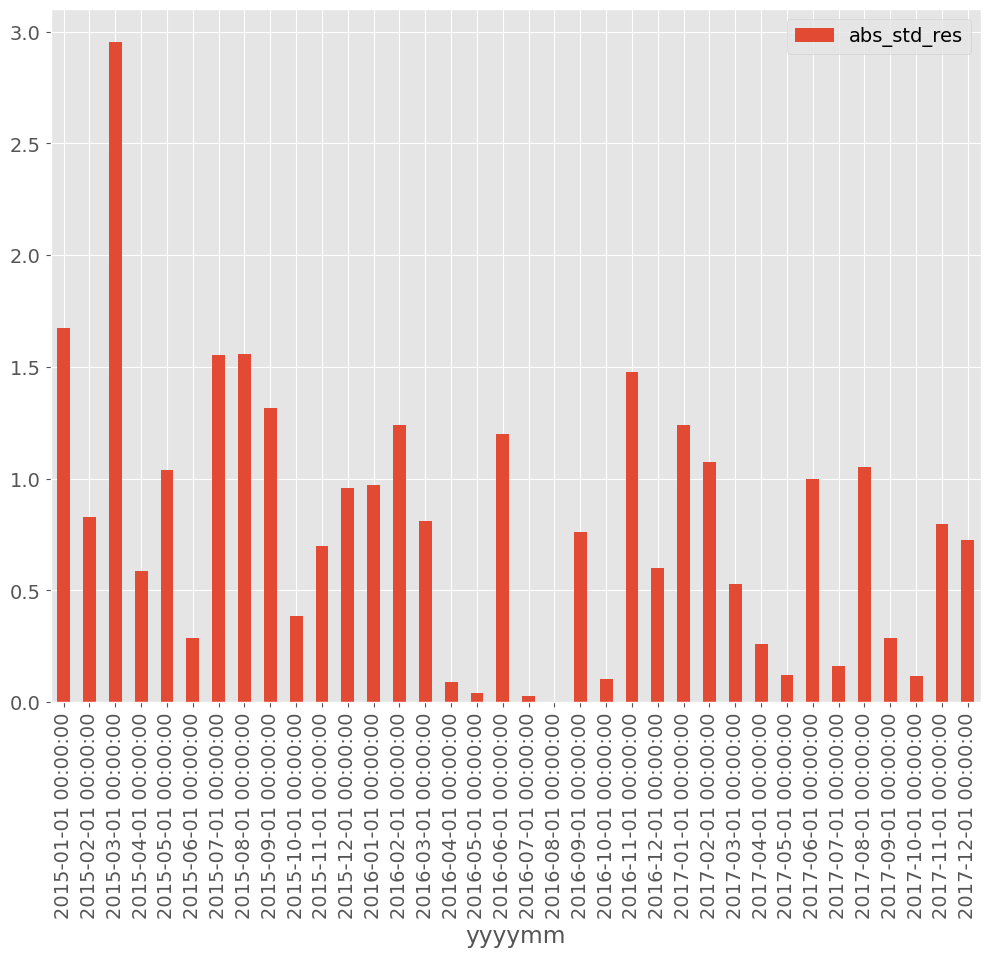

In [13]:
#
# グラフ化（外れ値スコア）
#

res_df.plot(kind='bar', y='abs_std_res')
plt.show()

## ステップ3：異常検知（評価対象データの期間）

### 評価対象データの期間を予測

In [14]:
#
# 予測の実施（評価対象データの期間）
#

target_pred = arima_model.predict(n_periods=target_length)

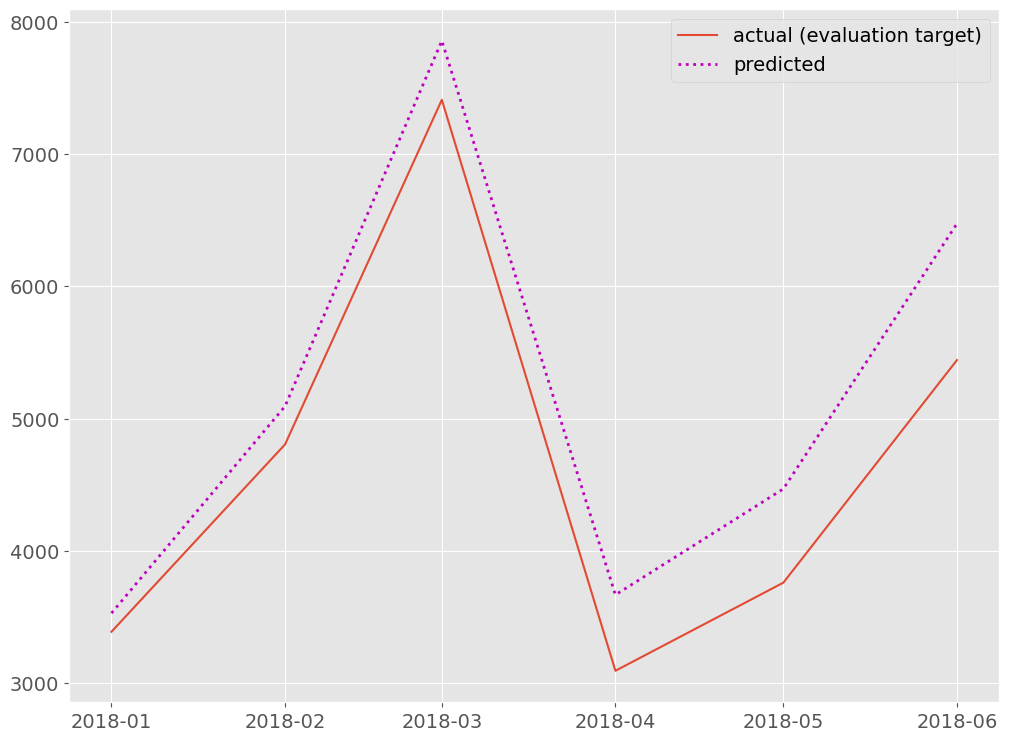

In [15]:
#
# グラフ化（予測値と実測値）
#

fig, ax = plt.subplots()

ax.plot(
    df_target.index, 
    df_target.sales, 
    label="actual (evaluation target)")
ax.plot(
    df_target.index, 
    target_pred, label="predicted", 
    linestyle="dotted", 
    lw=2,color="m")

ax.legend()
plt.show()

### 残差と外れ値スコアの計算

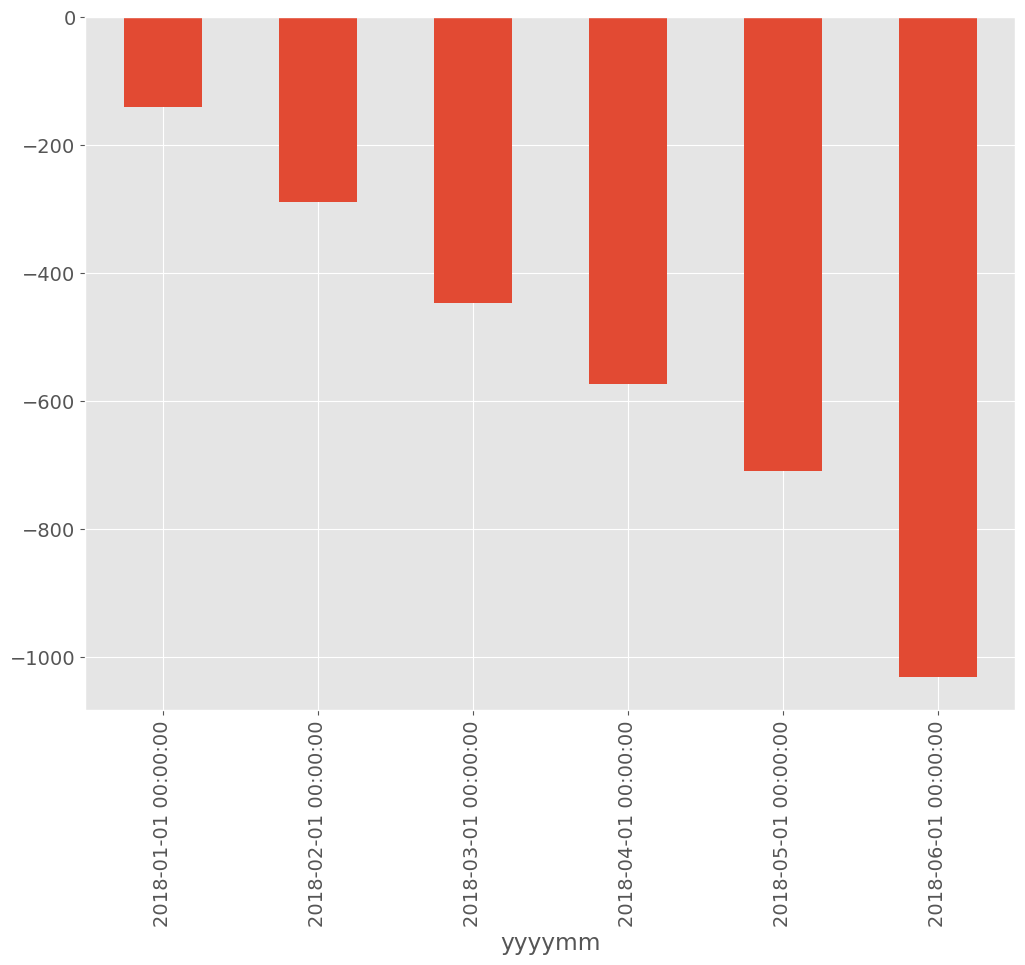

In [16]:
#
# 残差（実測値－予測値）
#

res = df_target.sales-target_pred

# グラフ化
res.plot(kind='bar')
plt.show()

In [17]:
#
# 標準化（平均0、分散1に正規化）
#

res_data = res.values.reshape(-1, 1) #NumPy配列に変換
res_data_ss = scaler.transform(res_data) #標準化

In [18]:
#
# 外れ値スコアなどを計算しtarget_res_dfに結果集約
#

target_res_df = df_target.copy() #日付と売上
target_res_df['pred'] = target_pred #予測値
target_res_df['residual'] = res_data #残差
target_res_df['std_res'] = res_data_ss #標準化した残差
target_res_df['abs_std_res'] = abs(res_data_ss) #外れ値スコア

# 確認
print(target_res_df)

            sales         pred     residual   std_res  abs_std_res
yyyymm                                                            
2018-01-01   3389  3529.609968  -140.609968 -0.408886     0.408886
2018-02-01   4805  5093.189186  -288.189186 -0.954684     0.954684
2018-03-01   7409  7855.173028  -446.173028 -1.538961     1.538961
2018-04-01   3094  3667.820021  -573.820021 -2.011042     2.011042
2018-05-01   3760  4468.740466  -708.740466 -2.510023     2.510023
2018-06-01   5442  6473.141947 -1031.141947 -3.702371     3.702371


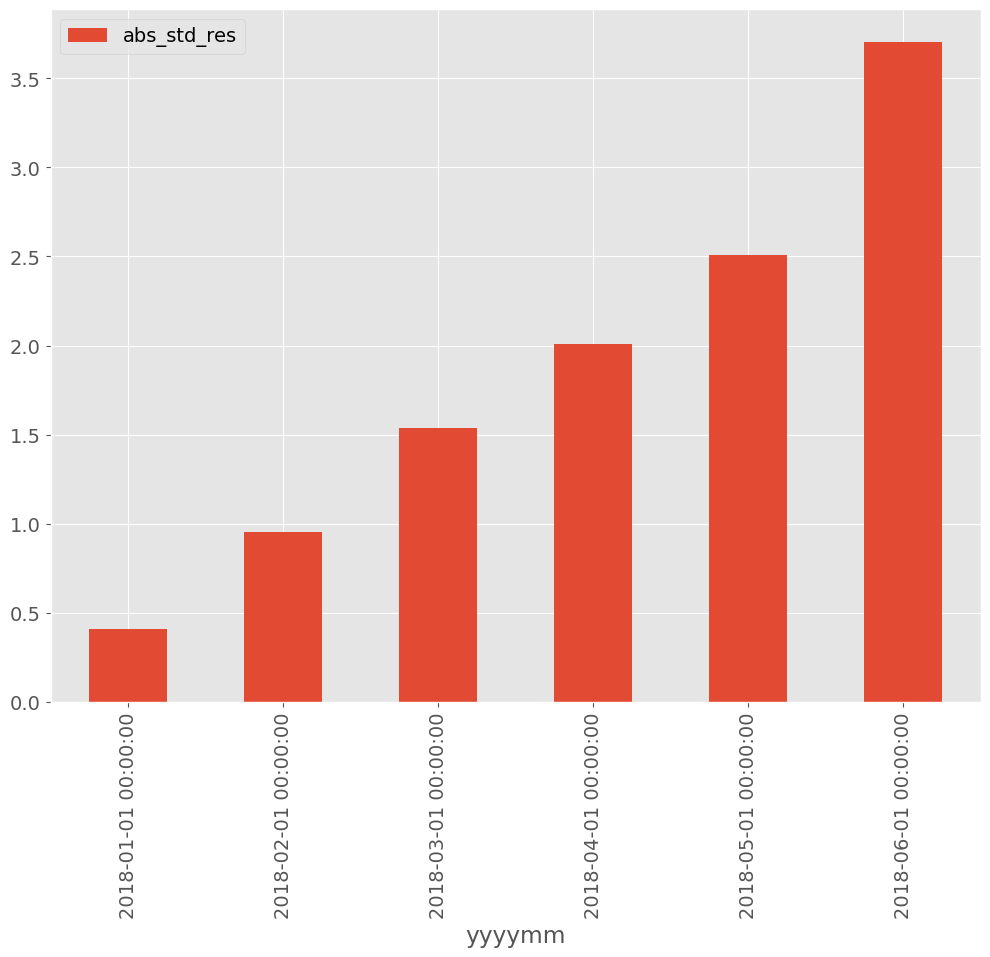

In [19]:
#
# グラフ化（外れ値スコア）
#

target_res_df.plot(
    kind='bar', y='abs_std_res')
plt.show()